# Hamming Kernel Application

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

from typing import Optional

import math
import numpy as np
import gpytorch
import torch
from torch import nn, Tensor
from torch.nn import functional as F

from gpytorch.constraints.constraints import Interval, Positive
from gpytorch.kernels.kernel import Kernel
from gpytorch.priors.prior import Prior

## Dataframe Reformatting

CSV converts everything to a string, so we have to undo the process for each column we want

In [3]:
# Run this line every time in order to refresh the data
df = pd.read_csv('processed/user_0162bdca5925e11a37a48c507453734045b5d62cca0d6abc8300993dfbf8b69e.csv')

# Add additional corrections as needed
df['last_one'] = df['last_one'].fillna(-1)
df['last_two'] = df['last_two'].apply(lambda x: np.fromstring(x[1 : len(x) - 1], dtype = float, sep = ','))
df['last_three'] = df['last_three'].apply(lambda x: np.fromstring(x[1 : len(x) - 1], dtype = float, sep = ','))
df['last_three_activity_duration'] = df['last_three_activity_duration'].apply(lambda x: np.fromstring(x[1 : len(x) - 1], dtype = float, sep = ','))
df['last_start_time'] = pd.to_datetime(df['last_start_time'])
df['leaving_datetime'] = pd.to_datetime(df['leaving_datetime'])

We also need to consider our hashing needs, so we'll need to convert our lists to tuples as needed:

In [4]:
# Note that lists are non-hashable, so we need to convert them to tuples
df['last_two'] = df['last_two'].apply(lambda x: tuple(x))
df['last_three'] = df['last_three'].apply(lambda x: tuple(x))
df['last_three_activity_duration'] = df['last_three_activity_duration'].apply(lambda x: tuple(x))

In [5]:
df

,datetime,leaving_datetime,cluster,dist,last_one,last_two,last_three,activity_duration,last_three_activity_duration,last_three_start_time,...,third_last_dist,last_start_time,second_last_start_time,third_last_start_time,last_end_time,second_last_end_time,third_last_end_time,last_activity_duration,second_last_activity_duration,third_last_activity_duration
0,2019-12-31 14:49:22,2019-12-31 15:58:02,0,58813.0,-1.0,"(nan, nan)","(nan, nan, nan)",69,"(nan, nan, nan)","(NaT, NaT, NaT)",...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-12-31 17:01:04,2019-12-31 19:45:05,6,52032.0,0.0,"(0.0, nan)","(0.0, nan, nan)",164,"(69.0, nan, nan)","(Timestamp('2019-12-31 14:49:22'), NaT, NaT)",...,NaN,2019-12-31 14:49:22,NaN,NaN,2019-12-31 15:58:02,NaN,NaN,69.0,NaN,NaN
2,2019-12-31 20:32:41,2020-01-01 01:35:33,3,38063.0,6.0,"(6.0, 0.0)","(6.0, 0.0, nan)",303,"(164.0, 69.0, nan)","(Timestamp('2019-12-31 17:01:04'), Timestamp('...",...,NaN,2019-12-31 17:01:04,2019-12-31 14:49:22,NaN,2019-12-31 19:45:05,2019-12-31 15:58:02,NaN,164.0,69.0,NaN
3,2020-01-01 02:41:51,2020-01-02 08:52:52,0,4705.0,3.0,"(3.0, 6.0)","(3.0, 6.0, 0.0)",1811,"(303.0, 164.0, 69.0)","(Timestamp('2019-12-31 20:32:41'), Timestamp('...",...,58813.0,2019-12-31 20:32:41,2019-12-31 17:01:04,2019-12-31 14:49:22,2020-01-01 01:35:33,2019-12-31 19:45:05,2019-12-31 15:58:02,303.0,164.0,69.0
4,2020-01-02 09:21:03,2020-01-02 14:45:51,1,4705.0,0.0,"(0.0, 3.0)","(0.0, 3.0, 6.0)",325,"(1811.0, 303.0, 164.0)","(Timestamp('2020-01-01 02:41:51'), Timestamp('...",...,52032.0,2020-01-01 02:41:51,2019-12-31 20:32:41,2019-12-31 17:01:04,2020-01-02 08:52:52,2020-01-01 01:35:33,2019-12-31 19:45:05,1811.0,303.0,164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,2020-06-23 18:25:28,2020-06-24 08:45:47,0,4705.0,1.0,"(1.0, 0.0)","(1.0, 0.0, 1.0)",860,"(130.0, 117.0, 246.0)","(Timestamp('2020-06-23 15:45:32'), Timestamp('...",...,4705.0,2020-06-23 15:45:32,2020-06-23 13:30:36,2020-06-23 09:09:49,2020-06-23 17:55:07,2020-06-23 15:27:16,2020-06-23 13:15:34,130.0,117.0,246.0
458,2020-06-24 09:06:58,2020-06-24 12:05:13,1,4705.0,0.0,"(0.0, 1.0)","(0.0, 1.0, 0.0)",178,"(860.0, 130.0, 117.0)","(Timestamp('2020-06-23 18:25:28'), Timestamp('...",...,4705.0,2020-06-23 18:25:28,2020-06-23 15:45:32,2020-06-23 13:30:36,2020-06-24 08:45:47,2020-06-23 17:55:07,2020-06-23 15:27:16,860.0,130.0,117.0
459,2020-06-24 12:28:29,2020-06-24 15:24:46,0,4705.0,1.0,"(1.0, 0.0)","(1.0, 0.0, 1.0)",176,"(178.0, 860.0, 130.0)","(Timestamp('2020-06-24 09:06:58'), Timestamp('...",...,4705.0,2020-06-24 09:06:58,2020-06-23 18:25:28,2020-06-23 15:45:32,2020-06-24 12:05:13,2020-06-24 08:45:47,2020-06-23 17:55:07,178.0,860.0,130.0
460,2020-06-24 15:40:02,2020-06-24 18:02:40,1,4705.0,0.0,"(0.0, 1.0)","(0.0, 1.0, 0.0)",143,"(176.0, 178.0, 860.0)","(Timestamp('2020-06-24 12:28:29'), Timestamp('...",...,4705.0,2020-06-24 12:28:29,2020-06-24 09:06:58,2020-06-23 18:25:28,2020-06-24 15:24:46,2020-06-24 12:05:13,2020-06-24 08:45:47,176.0,178.0,860.0


Observe that the altered data is in an appropriate format.

In [6]:
df[['cluster', 'last_one', 'last_two', 'last_three', 'last_three_activity_duration', 'last_start_time', 'leaving_datetime']]

,cluster,last_one,last_two,last_three,last_three_activity_duration,last_start_time,leaving_datetime
0,0,-1.0,"(nan, nan)","(nan, nan, nan)","(nan, nan, nan)",NaT,2019-12-31 15:58:02
1,6,0.0,"(0.0, nan)","(0.0, nan, nan)","(69.0, nan, nan)",2019-12-31 14:49:22,2019-12-31 19:45:05
2,3,6.0,"(6.0, 0.0)","(6.0, 0.0, nan)","(164.0, 69.0, nan)",2019-12-31 17:01:04,2020-01-01 01:35:33
3,0,3.0,"(3.0, 6.0)","(3.0, 6.0, 0.0)","(303.0, 164.0, 69.0)",2019-12-31 20:32:41,2020-01-02 08:52:52
4,1,0.0,"(0.0, 3.0)","(0.0, 3.0, 6.0)","(1811.0, 303.0, 164.0)",2020-01-01 02:41:51,2020-01-02 14:45:51
...,...,...,...,...,...,...,...
457,0,1.0,"(1.0, 0.0)","(1.0, 0.0, 1.0)","(130.0, 117.0, 246.0)",2020-06-23 15:45:32,2020-06-24 08:45:47
458,1,0.0,"(0.0, 1.0)","(0.0, 1.0, 0.0)","(860.0, 130.0, 117.0)",2020-06-23 18:25:28,2020-06-24 12:05:13
459,0,1.0,"(1.0, 0.0)","(1.0, 0.0, 1.0)","(178.0, 860.0, 130.0)",2020-06-24 09:06:58,2020-06-24 15:24:46
460,1,0.0,"(0.0, 1.0)","(0.0, 1.0, 0.0)","(176.0, 178.0, 860.0)",2020-06-24 12:28:29,2020-06-24 18:02:40


## Data Encoding/Decoding

In [7]:
# Use variables to specify the columns to encode
item1 = 'cluster'
item2 = 'last_two'

# Encode the data such that each combination of origin and destination is a unique number
# Create a list of unique last_two combinations
unique_combinations = df[[item1, item2]].drop_duplicates().reset_index(drop=True)

# Create a dictionary of unique origin-destination combinations
unique_combinations_dict = dict(zip(range(0, len(unique_combinations)), unique_combinations.values.tolist()))

# Create a function that encodes the origin-destination combinations
def encode_combinations(row, col1, col2):
    # Get the origin-destination combination
    combination = row[[col1, col2]].values.tolist()
    # Get the index of the combination
    index = list(unique_combinations_dict.values()).index(combination)
    # Return the index
    return index

# Create a function that decodes the origin-destination combinations
def decode_combinations(row):
    # Get the index
    index = row['combinations']
    # Get the origin-destination combination
    combination = unique_combinations_dict[index]
    # Return the combination
    return combination

# Encode the origins and destinations
df['combinations'] = df.apply(lambda x: encode_combinations(x, item1, item2), axis=1)
df['combinations']

0      0
1      1
2      2
3      3
4      4
      ..
457    5
458    6
459    5
460    6
461    5
Name: combinations, Length: 462, dtype: int64

In [8]:
print("There are {} unique combinations of stays and last two stays.".format(len(df['combinations'].unique())))

There are 73 unique combinations of stays and last two stays.


## Plotting

In [9]:
# Get all rows where cluster == 0 and the second value of last_two is 0
one_stop_hbt = df[(df['cluster'] == 0) & (df['last_two'].apply(lambda x: x[1]) == '0.0')]

# Get all rows where cluster == 0 and the third value of last_three is 0
two_stop_hbt = df[(df['cluster'] == 0) & (df['last_three'].apply(lambda x: x[2]) == '0.0')]

In [10]:
one_stop_hbt.head()

,datetime,leaving_datetime,cluster,dist,last_one,last_two,last_three,activity_duration,last_three_activity_duration,last_three_start_time,...,last_start_time,second_last_start_time,third_last_start_time,last_end_time,second_last_end_time,third_last_end_time,last_activity_duration,second_last_activity_duration,third_last_activity_duration,combinations


In [11]:
two_stop_hbt.head()

,datetime,leaving_datetime,cluster,dist,last_one,last_two,last_three,activity_duration,last_three_activity_duration,last_three_start_time,...,last_start_time,second_last_start_time,third_last_start_time,last_end_time,second_last_end_time,third_last_end_time,last_activity_duration,second_last_activity_duration,third_last_activity_duration,combinations


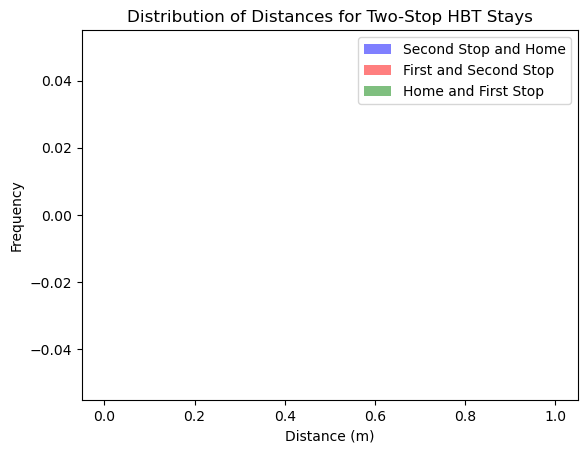

In [12]:
# Distribution of distances for all two_stop_hbt stays
plt.hist(two_stop_hbt['last_dist'], bins=30, color='blue', alpha=0.5, label='Second Stop and Home')
plt.hist(two_stop_hbt['second_last_dist'], bins=30, color='red', alpha=0.5, label='First and Second Stop')
plt.hist(two_stop_hbt['third_last_dist'], bins=30, color='green', alpha=0.5, label='Home and First Stop')
plt.title("Distribution of Distances for Two-Stop HBT Stays")
plt.xlabel("Distance (m)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

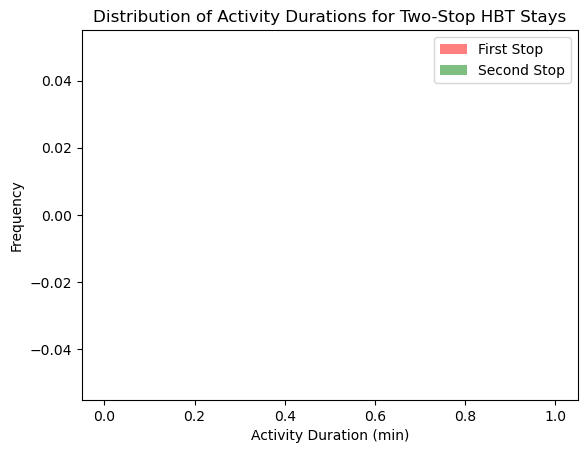

In [13]:
# Activity duration for all two_stop_hbt stays
#plt.hist(two_stop_hbt['last_three_activity_duration'].apply(lambda x: x[0]), bins=20, color='blue', alpha=0.5, label='Second Stop and Home')
plt.hist(two_stop_hbt['last_activity_duration'], bins=30, color='red', alpha=0.5, label='First Stop')
plt.hist(two_stop_hbt['second_last_activity_duration'], bins=30, color='green', alpha=0.5, label='Second Stop')
plt.title("Distribution of Activity Durations for Two-Stop HBT Stays")
plt.xlabel("Activity Duration (min)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

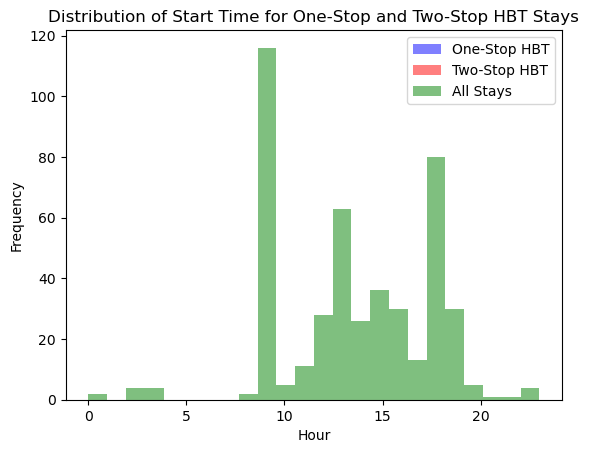

In [14]:
# Plot the distribution of hours for one_stop_hbt stays, two_stop_hbt stays, and all stays
plt.hist(one_stop_hbt['last_start_time'].dt.hour, bins=24, color='blue', alpha=0.5, label='One-Stop HBT')
plt.hist(two_stop_hbt['last_start_time'].dt.hour, bins=24, color='red', alpha=0.5, label='Two-Stop HBT')
plt.hist(df['last_start_time'].dt.hour, bins=24, color='green', alpha=0.5, label='All Stays')
plt.title("Distribution of Start Time for One-Stop and Two-Stop HBT Stays")
plt.xlabel("Hour")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Hamming Kernel Code

In [15]:
EMPTY_SIZE = torch.Size([])


class HammingIMQKernel(Kernel):
    r"""
    Computes a covariance matrix based on the inverse multiquadratic Hamming kernel
    between inputs :math:`\mathbf{x_1}` and :math:`\mathbf{x_2}`:

    .. math::
       \begin{equation*}
            k_{\text{H-IMQ}}(\mathbf{x_1}, \mathbf{x_2}) =
            \left( \frac{1 + \alpha}{\alpha + d_{\text{Hamming}}(x1, x2)} \right)^\beta
       \end{equation*}
    where :math:`\alpha` and :math:`\beta` are strictly positive scale parameters.
    This kernel was proposed in `Biological Sequence Kernels with Guaranteed Flexibility`.
    See http://arxiv.org/abs/2304.03775 for more details.

    This kernel is meant to be used for fixed-length one-hot encoded discrete sequences.
    Because GPyTorch is particular about dimensions, the one-hot sequence encoding should be flattened
    to a vector with length :math:`T \times V`, where :math:`T` is the sequence length and :math:`V` is the
    vocabulary size.

    :param vocab_size: The size of the vocabulary.
    :param batch_shape: Set this if you want a separate kernel hyperparameters for each batch of input
        data. It should be :math:`B_1 \times \ldots \times B_k` if :math:`\mathbf{x_1}` is
        a :math:`B_1 \times \ldots \times B_k \times N \times D` tensor.
    :param alpha_prior: Set this if you want to apply a prior to the
        alpha parameter.
    :param: alpha_constraint: Set this if you want to apply a constraint
        to the alpha parameter. If None is passed, the default is `Positive()`.
    :param beta_prior: Set this if you want to apply a prior to the
        beta parameter.
    :param beta_constraint: Set this if you want to apply a constraint
        to the beta parameter. If None is passed, the default is `Positive()`.

    Example:
        >>> vocab_size = 8
        >>> x_cat = torch.tensor([[7, 7, 7, 7], [5, 7, 3, 4]])  # batch_size x seq_length
        >>> x_one_hot = F.one_hot(x_cat, num_classes=vocab_size)  # batch_size x seq_length x vocab_size
        >>> x_flat = x_one_hot.view(*x_cat.shape[:-1], -1)  # batch_size x (seq_length * vocab_size)
        >>> covar_module = gpytorch.kernels.HammingIMQKernel(vocab_size=vocab_size)
        >>> covar = covar_module(x_flat)  # Output: LinearOperator of size (2 x 2)
    """

    def __init__(
        self,
        vocab_size: int,
        batch_shape: torch.Size = EMPTY_SIZE,
        alpha_prior: Optional[Prior] = None,
        alpha_constraint: Optional[Interval] = None,
        beta_prior: Optional[Prior] = None,
        beta_constraint: Optional[Interval] = None,
    ):
        super().__init__(batch_shape=batch_shape)
        self.vocab_size = vocab_size
        # add alpha (scale) parameter
        alpha_constraint = Positive() if alpha_constraint is None else alpha_constraint
        self.register_parameter(
            name="raw_alpha",
            parameter=nn.Parameter(torch.zeros(*self.batch_shape, 1)),
        )
        if alpha_prior is not None:
            self.register_prior("alpha_prior", alpha_prior, self._alpha_param, self._alpha_closure)
        self.register_constraint("raw_alpha", alpha_constraint)

        # add beta parameter
        beta_constraint = Positive() if beta_constraint is None else beta_constraint
        self.register_parameter(
            name="raw_beta",
            parameter=nn.Parameter(torch.zeros(*self.batch_shape, 1)),
        )
        if beta_prior is not None:
            self.register_prior("beta_prior", beta_prior, self._beta_param, self._beta_closure)
        self.register_constraint("raw_beta", beta_constraint)

    @property
    def alpha(self) -> Tensor:
        return self.raw_alpha_constraint.transform(self.raw_alpha)

    @alpha.setter
    def alpha(self, value: Tensor):
        self._set_alpha(value)

    def _alpha_param(self, m: Kernel) -> Tensor:
        # Used by the alpha_prior
        return m.alpha

    def _alpha_closure(self, m: Kernel, v: Tensor) -> Tensor:
        # Used by the alpha_prior
        return m._set_alpha(v)

    def _set_alpha(self, value: Tensor):
        # Used by the alpha_prior
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_alpha)
        self.initialize(raw_alpha=self.raw_alpha_constraint.inverse_transform(value))

    @property
    def beta(self) -> Tensor:
        return self.raw_beta_constraint.transform(self.raw_beta)

    @beta.setter
    def beta(self, value: Tensor):
        self._set_beta(value)

    def _beta_param(self, m: Kernel) -> Tensor:
        # Used by the beta_prior
        return m.beta

    def _beta_closure(self, m: Kernel, v: Tensor) -> Tensor:
        # Used by the beta_prior
        return m._set_beta(v)

    def _set_beta(self, value: Tensor):
        # Used by the beta_prior
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_beta)
        self.initialize(raw_beta=self.raw_beta_constraint.inverse_transform(value))

    def _imq(self, dist: Tensor) -> Tensor:
        return ((1 + self.alpha) / (self.alpha + dist)).pow(self.beta)

    def forward(self, x1: Tensor, x2: Tensor, diag: bool = False, **params):
        # GPyTorch is pretty particular about dimensions so we need to unflatten the one-hot encoding
        x1 = x1.view(*x1.shape[:-1], -1, self.vocab_size)
        x2 = x2.view(*x2.shape[:-1], -1, self.vocab_size)

        x1_eq_x2 = torch.equal(x1, x2)

        if diag:
            if x1_eq_x2:
                res = ((1 + self.alpha) / self.alpha).pow(self.beta)
                skip_dims = [-1] * len(self.batch_shape)
                return res.expand(*skip_dims, x1.size(-3))
            else:
                dist = x1.size(-2) - (x1 * x2).sum(dim=(-1, -2))
                return self._imq(dist)

        else:
            dist = hamming_dist(x1, x2, x1_eq_x2)

        return self._imq(dist)


def hamming_dist(x1: Tensor, x2: Tensor, x1_eq_x2: bool) -> Tensor:
    res = x1.size(-2) - (x1.unsqueeze(-3) * x2.unsqueeze(-4)).sum(dim=(-1, -2))
    if x1_eq_x2 and not x1.requires_grad and not x2.requires_grad:
        res.diagonal(dim1=-2, dim2=-1).fill_(0)
    # Zero out negative values
    #print(res.clamp_min_(0))
    return res.clamp_min_(0)

## Predictive Modeling

### Predict the Next Location Using Last 2 Locations

We want to predict the current cluster location given the last two locations.

First, we set up our train and test data. This will be the standard format of an 80/20 split.

In [16]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

dummies = pd.get_dummies(df['last_two']).values

# connect old data fram with new one horizontally
new_df = pd.concat([df, pd.DataFrame(dummies)], axis=1)
train_set, test_set = train_test_split(new_df, test_size = 0.2, random_state=42)

# x_train is last 48 columns of train_set
x_train = torch.tensor(train_set.iloc[:, -dummies.shape[1]:].values, dtype=torch.float32)
print("training shape:", x_train.shape)

# x_test is last 48 columns of test_set
x_test = torch.tensor(test_set.iloc[:, -dummies.shape[1]:].values, dtype=torch.float32)
print("testing shape:", x_test.shape)

training shape: torch.Size([369, 48])
testing shape: torch.Size([93, 48])


Set up our y data and define our model

In [17]:
# Convert cluster column to tensor
y_train = torch.tensor(train_set['cluster'].values, dtype=torch.float32)
y_actual = torch.tensor(test_set['cluster'].values, dtype=torch.float32)

# The number of unique locations
num_unique = dummies.shape[1]

# Use the simplest form of GP model, exact inference
class GPModelMk1(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = HammingIMQKernel(vocab_size=num_unique)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x) 
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

Here, we set up our convenience functions

In [18]:
# Wrap training and prediction into functions, since we'll call them again later
def train(model, likelihood, training_iter=training_iter):
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(x_train)
        # Calc loss and backprop gradients
        loss = -mll(output, y_train)
        loss.backward()
        optimizer.step()    

def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        return likelihood(model(test_x))

In [19]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModelMk1(x_train, y_train, likelihood)

# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

# set to evaluation mode and predict
model.eval()
likelihood.eval()
observed_prediction = predict(model, likelihood, x_test)

Now let's take a look at our results!

In [20]:

# get predicted clusters
predicted_clusters = torch.clone(observed_prediction.mean)

# convert data type to integer
predicted_clusters = predicted_clusters.type(torch.int32)

print("Using the last two locations, we predict the next location (current cluster) with an accuracy of: ", 
      '%.2f'%(torch.eq(y_actual, predicted_clusters).sum().item() / len(y_actual) * 100), "%", sep="")

Using the last two locations, we predict the next location (current cluster) with an accuracy of: 68.82%


### Predict the Next Location Using Last 3 Locations

We want to predict the current location given the last 3 locations.

In [21]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

dummies = pd.get_dummies(df['last_three']).values

# connect old data fram with new one horizontally
new_df = pd.concat([df, pd.DataFrame(dummies)], axis=1)
train_set, test_set = train_test_split(new_df, test_size = 0.2, random_state=42)

# x_train is last 74 columns of train_set
x_train = torch.tensor(train_set.iloc[:, -dummies.shape[1]:].values, dtype=torch.float32)
print("training shape:", x_train.shape)

# x_test is last 74 columns of test_set
x_test = torch.tensor(test_set.iloc[:, -dummies.shape[1]:].values, dtype=torch.float32)
print("testing shape:", x_test.shape)

# Convert cluster column to tensor
y_train = torch.tensor(train_set['cluster'].values, dtype=torch.float32)
y_actual = torch.tensor(test_set['cluster'].values, dtype=torch.float32)

# The number of unique locations
num_unique = dummies.shape[1]

training shape: torch.Size([369, 74])
testing shape: torch.Size([93, 74])


Initialize our model and get results

In [22]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModelMk1(x_train, y_train, likelihood)

# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

# set to evaluation mode and predict
model.eval()
likelihood.eval()
observed_prediction = predict(model, likelihood, x_test)

# get predicted clusters
predicted_clusters = torch.clone(observed_prediction.mean)

# convert data type to integer
predicted_clusters = predicted_clusters.type(torch.int32)

print("Using the last two locations, we predict the next location (current cluster) with an accuracy of: ", 
      '%.2f'%(torch.eq(y_actual, predicted_clusters).sum().item() / len(y_actual) * 100), "%", sep="")

Using the last two locations, we predict the next location (current cluster) with an accuracy of: 63.44%


Interestingly, we see that using the past three locations by itself is worse than the past two locations.

This is possibly due to having more unique clusters, and thus, less confidence in the training.

### Predicting Current Location Based on Last Activity and Time of Day

First we encode our combination and set up our data

In [23]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Append additional leaving datetime hour column to df
df['leaving_hour'] = df['leaving_datetime'].dt.hour

# Turn leaving hour column into integer
df['leaving_hour'] = df['leaving_hour'].astype(int)

# Use variables to specify the columns to encode
item1 = 'last_one'
item2 = 'leaving_hour'

# Encode the data such that each combination of origin and destination is a unique number
# Create a list of unique last_two combinations
unique_combinations = df[[item1, item2]].drop_duplicates().reset_index(drop=True)

# Create a dictionary of unique origin-destination combinations
unique_combinations_dict = dict(zip(range(0, len(unique_combinations)), unique_combinations.values.tolist()))

# Encode the origins and destinations
df['combinations'] = df.apply(lambda x: encode_combinations(x, item1, item2), axis=1)

# Get training and testing data
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)

# Get x data
x_train = torch.tensor(train_set['combinations'].values, dtype=torch.float32)
x_test = torch.tensor(test_set['combinations'].values, dtype=torch.float32)

# Convert cluster column to tensor
y_train = torch.tensor(train_set['cluster'].values, dtype=torch.float32)
y_actual = torch.tensor(test_set['cluster'].values, dtype=torch.float32)

Now we define our basic regression model 

In [24]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood)

Now we train, test, and plot our data

In [25]:
# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

# set to evaluation mode and predict
model.eval()
likelihood.eval()
observed_prediction = predict(model, likelihood, x_test)

In [26]:
torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int)

/var/folders/9q/4yjzjfts7dl9f0m7h5315w200000gp/T/ipykernel_23065/1286424123.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int)


tensor([ 0,  0,  0,  0, -2,  0,  0, -3,  0,  0,  0,  0,  0,  0,  1,  0,  0,  7,
         0, -2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        -2,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -2,  0,  0,  0,  0, -1,  0,
         0,  0,  0,  0,  0, -2,  0, -2, -2,  0,  0, -2, -2,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, -2,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0], dtype=torch.int32)

In [27]:
# get predicted clusters
predicted_clusters = torch.clone(observed_prediction.mean)

# convert data type to integer
predicted_clusters = predicted_clusters.type(torch.int32)

print("We predict the next location (current cluster) with an accuracy of: ", 
      '%.2f'%(torch.eq(y_actual, predicted_clusters).sum().item() / len(y_actual) * 100), "%", sep="")

We predict the next location (current cluster) with an accuracy of: 78.49%


As we can see, this is the best prediction accuracy so far by nearly 10%! 

### Predicting Current Location Via Last Location, Time of Day, and Day of Week

Set up our data.

In [28]:
# First we add an additional day-of-week column to the dataframe
df['day_of_week'] = df['leaving_datetime'].dt.dayofweek # Monday = 0, Sunday = 6

# Now we want to know if the day of the week is a weekday or weekend
df['is_weekday'] = df['day_of_week'].apply(lambda x: 1 if x < 5 else 0)

# Encapsulate the features we want to examine
features = ['last_one', 'leaving_hour', 'is_weekday']

# Get training and testing data
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)

# Get x data
x_train = torch.tensor(train_set[features].values, dtype=torch.float32)
x_test = torch.tensor(test_set[features].values, dtype=torch.float32)

# Convert cluster column to tensor
y_train = torch.tensor(train_set['cluster'].values, dtype=torch.float32)
y_actual = torch.tensor(test_set['cluster'].values, dtype=torch.float32)




,datetime,leaving_datetime,cluster,dist,last_one,last_two,last_three,activity_duration,last_three_activity_duration,last_three_start_time,...,last_end_time,second_last_end_time,third_last_end_time,last_activity_duration,second_last_activity_duration,third_last_activity_duration,combinations,leaving_hour,day_of_week,is_weekday
0,2019-12-31 14:49:22,2019-12-31 15:58:02,0,58813.0,-1.0,"(nan, nan)","(nan, nan, nan)",69,"(nan, nan, nan)","(NaT, NaT, NaT)",...,NaN,NaN,NaN,NaN,NaN,NaN,0,15,1,1
1,2019-12-31 17:01:04,2019-12-31 19:45:05,6,52032.0,0.0,"(0.0, nan)","(0.0, nan, nan)",164,"(69.0, nan, nan)","(Timestamp('2019-12-31 14:49:22'), NaT, NaT)",...,2019-12-31 15:58:02,NaN,NaN,69.0,NaN,NaN,1,19,1,1
2,2019-12-31 20:32:41,2020-01-01 01:35:33,3,38063.0,6.0,"(6.0, 0.0)","(6.0, 0.0, nan)",303,"(164.0, 69.0, nan)","(Timestamp('2019-12-31 17:01:04'), Timestamp('...",...,2019-12-31 19:45:05,2019-12-31 15:58:02,NaN,164.0,69.0,NaN,2,1,2,1
3,2020-01-01 02:41:51,2020-01-02 08:52:52,0,4705.0,3.0,"(3.0, 6.0)","(3.0, 6.0, 0.0)",1811,"(303.0, 164.0, 69.0)","(Timestamp('2019-12-31 20:32:41'), Timestamp('...",...,2020-01-01 01:35:33,2019-12-31 19:45:05,2019-12-31 15:58:02,303.0,164.0,69.0,3,8,3,1
4,2020-01-02 09:21:03,2020-01-02 14:45:51,1,4705.0,0.0,"(0.0, 3.0)","(0.0, 3.0, 6.0)",325,"(1811.0, 303.0, 164.0)","(Timestamp('2020-01-01 02:41:51'), Timestamp('...",...,2020-01-02 08:52:52,2020-01-01 01:35:33,2019-12-31 19:45:05,1811.0,303.0,164.0,4,14,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,2020-06-23 18:25:28,2020-06-24 08:45:47,0,4705.0,1.0,"(1.0, 0.0)","(1.0, 0.0, 1.0)",860,"(130.0, 117.0, 246.0)","(Timestamp('2020-06-23 15:45:32'), Timestamp('...",...,2020-06-23 17:55:07,2020-06-23 15:27:16,2020-06-23 13:15:34,130.0,117.0,246.0,19,8,2,1
458,2020-06-24 09:06:58,2020-06-24 12:05:13,1,4705.0,0.0,"(0.0, 1.0)","(0.0, 1.0, 0.0)",178,"(860.0, 130.0, 117.0)","(Timestamp('2020-06-23 18:25:28'), Timestamp('...",...,2020-06-24 08:45:47,2020-06-23 17:55:07,2020-06-23 15:27:16,860.0,130.0,117.0,30,12,2,1
459,2020-06-24 12:28:29,2020-06-24 15:24:46,0,4705.0,1.0,"(1.0, 0.0)","(1.0, 0.0, 1.0)",176,"(178.0, 860.0, 130.0)","(Timestamp('2020-06-24 09:06:58'), Timestamp('...",...,2020-06-24 12:05:13,2020-06-24 08:45:47,2020-06-23 17:55:07,178.0,860.0,130.0,17,15,2,1
460,2020-06-24 15:40:02,2020-06-24 18:02:40,1,4705.0,0.0,"(0.0, 1.0)","(0.0, 1.0, 0.0)",143,"(176.0, 178.0, 860.0)","(Timestamp('2020-06-24 12:28:29'), Timestamp('...",...,2020-06-24 15:24:46,2020-06-24 12:05:13,2020-06-24 08:45:47,176.0,178.0,860.0,6,18,2,1


Now we train and evaluate our regression!

In [29]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood)

# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

# set to evaluation mode and predict
model.eval()
likelihood.eval()
observed_prediction = predict(model, likelihood, x_test)

In [30]:
torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int)

/var/folders/9q/4yjzjfts7dl9f0m7h5315w200000gp/T/ipykernel_23065/1286424123.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int)


tensor([ 0,  0,  0,  0, -2,  0,  0, -2,  0,  0,  0,  0,  0,  0,  1,  0,  0,  7,
         0, -3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        -2,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -2,  0,
         0,  0,  0,  0,  0,  0,  0, -3, -2,  0,  0, -1, -2,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, -3,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0], dtype=torch.int32)

In [31]:
# get predicted clusters
predicted_clusters = torch.clone(observed_prediction.mean)

# convert data type to integer
predicted_clusters = predicted_clusters.type(torch.int32)

print("We predict the next location (current cluster) with an accuracy of: ", 
      '%.2f'%(torch.eq(y_actual, predicted_clusters).sum().item() / len(y_actual) * 100), "%", sep="")

We predict the next location (current cluster) with an accuracy of: 79.57%


### Random Forest Baseline

We use Random Forest as a baseline for comparing our above results. Code may be modified to fit any of the above examples.

In [32]:
import scipy.stats 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

class RandomForest: 
    """
    A majority vote random forest classifier
    """
    
    def __init__(self, num_trees, max_depth=None):
        """
        Constructs a RandomForest that uses the given number of trees, each with a 
        max depth of max_depth.
        """
        self._trees = [
            DecisionTreeClassifier(max_depth=max_depth, random_state=1) 
            for i in range(num_trees)
        ]
        
    def fit(self, X):
        """
        Takes an input dataset X and trains each tree on a random subset of the data.
        Sampling is done with replacement.
        """

        for mini_tree in self._trees:
            mini_data = X.iloc[np.random.randint(0, X.shape[0], X.shape[0])]
            mini_tree.fit(mini_data['combinations'].to_numpy().reshape(-1, 1), mini_data['cluster'])
            
    def predict(self, X):
        """
        Takes an input dataset X and returns the predictions for each example in X.
        """
        # Builds up a 2d array with n rows and T columns
        # where n is the number of points to classify and T is the number of trees
        predictions = np.zeros((len(X), len(self._trees)))
        for i, tree in enumerate(self._trees):
            # Make predictions using the current tree
            preds = tree.predict(X)
            
            # Store those predictions in ith column of the 2d array
            predictions[:, i] = preds
            
        # For each row of predictions, find the most frequent label (axis=1 means across columns)
        return scipy.stats.mode(predictions, axis=1, keepdims=False)[0]

With the above filled in, we run our baseline:

In [33]:
# First calculate the accuracies for each depth
depths = list(range(1, 26, 2))
rf_accuracies = []
best_depth = 0
best_accuracy = 0

for i in depths:
    # Train and evaluate our RandomForest classifier with given max_depth 
    forest = RandomForest(15, max_depth=i)
    forest.fit(train_set)
    train_score = accuracy_score(forest.predict(train_set['combinations'].to_numpy().reshape(-1, 1)), train_set['cluster'])
    test_score = accuracy_score(forest.predict(test_set['combinations'].to_numpy().reshape(-1, 1)), test_set['cluster'])
    rf_accuracies.append((train_score, test_score))
    
    if test_score > best_accuracy:
        best_accuracy = test_score
        best_depth = i

print("Best Accuracy: ", best_accuracy, "\nBest Depth: ", best_depth, sep="")

Best Accuracy: 0.9139784946236559
Best Depth: 23
